In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
results_dir = "Analyzer Results"

recording_order = [15, 2, 1, 6, 10, 4]

In [4]:
# interpulse intervals
IPI = {

    "ASR_control":      None,
    "gap_depth":        50,
    "gap_duration_10":  10,
    "gap_duration_20":  20,
    "gap_duration_4":   4,
    "gap_duration_50":  50,
    "gap_duration_8":   8,
    "offset_ASR":       10,
    "offset_PPI_10":    10,
    "offset_PPI_12":    12,
    "offset_PPI_14":    14,
    "offset_PPI_16":    16,
    "offset_PPI_18":    18,
    "offset_PPI_20":    20,
    "offset_PPI_4":     4,
    "offset_PPI_6":     6,
    "offset_PPI_8":     8,
    "offset_PPI_50":    50,
    "tone_in_noise":    50

}

In [5]:
prepulse_intensity = {

    "ASR_control":      None,
    "gap_depth":        30,
    "gap_duration_10":  60,
    "gap_duration_20":  60,
    "gap_duration_4":   60,
    "gap_duration_50":  60,
    "gap_duration_8":   60,
    "offset_ASR":       60,
    "offset_PPI_10":    0,
    "offset_PPI_12":    0,
    "offset_PPI_14":    0,
    "offset_PPI_16":    0,
    "offset_PPI_18":    0,
    "offset_PPI_20":    0,
    "offset_PPI_4":     0,
    "offset_PPI_6":     0,
    "offset_PPI_8":     0,
    "offset_PPI_50":    0,
    "tone_in_noise":    80
}

In [6]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MTT', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_TT', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP']
Fit dataframes: ['RESULTS_FIT', 'RESULTS_MERGED_DATE_FIT', 'RESULTS_MERGED_EXP_FIT', 'RESULTS_MERGED_FIT', 'RESULTS_MTT_FIT', 'RESULTS_MTT_MERGED_DATE_FIT', 'RESULTS_MTT_MERGED_EXP_FIT', 'RESULTS_MTT_MERGED_FIT', 'RESULTS_TT_FIT', 'RESULTS_TT_MERGED_DATE_FIT', 'RESULTS_TT_MERGED_EXP_FIT', 'RESULTS_TT_MERGED_FIT']
Found 12 raw and 12 fit dataframes in Analyzer Results.

Found 18 experiments, 10 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_PPI_14, offset_PPI_16, offset_PPI_18, offset_PPI_20, offset_PPI_50
 reactionTime, peakTime, difference, pe

---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

In [ ]:
# facilitation if IPI >= 30?
import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()  # <-- .copy() to avoid SettingWithCopyWarning

# Create boolean columns
df_valid['IPI_ge_30'] = df_valid['IPI'] >= 30
df_valid['percentPPI_neg'] = df_valid[percentPPI_col] < 0

# Contingency table
table = pd.crosstab(df_valid['IPI_ge_30'], df_valid['percentPPI_neg'])

print(f"Contingency table (IPI >= 30 vs {percentPPI_col} < 0):")
print(table)

# Fisher's exact test (for 2x2 table)
if table.shape == (2, 2):
    oddsratio, p = fisher_exact(table)
    print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

# Also show proportions
prop_high_IPI = df_valid[df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
prop_low_IPI = df_valid[~df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
print(f"Proportion with {percentPPI_col} < 0 for IPI >= 30: {prop_high_IPI:.2f}")
print(f"Proportion with {percentPPI_col} < 0 for IPI < 30: {prop_low_IPI:.2f}")

Contingency table (IPI >= 30 vs percentPPI < 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False             201     33
True               51     21
Fisher's exact test: odds ratio = 2.51, p-value = 0.0073
Proportion with percentPPI < 0 for IPI >= 30: 0.29
Proportion with percentPPI < 0 for IPI < 30: 0.14


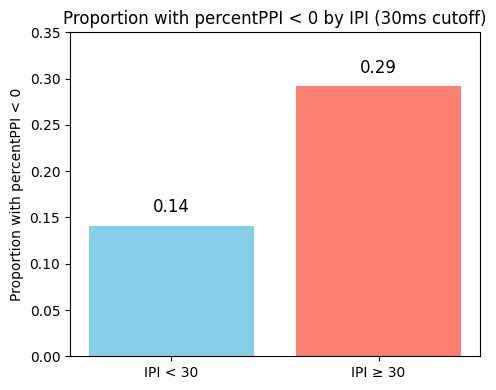

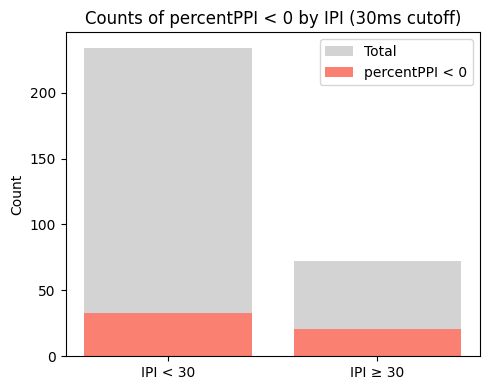

In [21]:
import matplotlib.pyplot as plt

# Data from contingency table
labels = ['IPI < 30', 'IPI ≥ 30']
counts_total = [201 + 33, 51 + 21]
counts_neg = [33, 21]
proportions = [33 / (201 + 33), 21 / (51 + 21)]

# Bar plot: proportion with percentPPI < 0
plt.figure(figsize=(5, 4))
plt.bar(labels, proportions, color=['skyblue', 'salmon'])
plt.ylabel('Proportion with percentPPI < 0')
plt.title('Proportion with percentPPI < 0 by IPI (30ms cutoff)')
for i, v in enumerate(proportions):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 0.35)
plt.tight_layout()
plt.show()

# Optional: stacked bar plot for counts
plt.figure(figsize=(5, 4))
plt.bar(labels, counts_total, color='lightgray', label='Total')
plt.bar(labels, counts_neg, color='salmon', label='percentPPI < 0')
plt.ylabel('Count')
plt.title('Counts of percentPPI < 0 by IPI (30ms cutoff)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# facilitation if IPI >= 30?
import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Split by sex and date
for sex in df_valid['sex'].unique():
    for date in df_valid['date'].unique():
        sub = df_valid[(df_valid['sex'] == sex) & (df_valid['date'] == date)].copy()
        if sub.empty:
            continue
        sub['IPI_ge_30'] = sub['IPI'] >= 30
        sub['percentPPI_neg'] = sub[percentPPI_col] < 0
        table = pd.crosstab(sub['IPI_ge_30'], sub['percentPPI_neg'])
        print(f"\nSex: {sex}, Date: {date}")
        print(f"Contingency table (IPI >= 30 vs {percentPPI_col} < 0):")
        print(table)
        if table.shape == (2, 2):
            oddsratio, p = fisher_exact(table)
            print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
        else:
            print("Not a 2x2 table, Fisher's exact test not applicable.")
        prop_high_IPI = sub[sub['IPI_ge_30']]['percentPPI_neg'].mean()
        prop_low_IPI = sub[~sub['IPI_ge_30']]['percentPPI_neg'].mean()
        print(f"Proportion with {percentPPI_col} < 0 for IPI >= 30: {prop_high_IPI:.2f}")
        print(f"Proportion with {percentPPI_col} < 0 for IPI < 30: {prop_low_IPI:.2f}")


Sex: female, Date: April16
Contingency table (IPI >= 30 vs percentPPI < 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False              32      7
True                8      4
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI < 0 for IPI >= 30: 0.33
Proportion with percentPPI < 0 for IPI < 30: 0.18

Sex: female, Date: June26
Contingency table (IPI >= 30 vs percentPPI < 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False              32      7
True                8      4
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI < 0 for IPI >= 30: 0.33
Proportion with percentPPI < 0 for IPI < 30: 0.18

Sex: female, Date: May20
Contingency table (IPI >= 30 vs percentPPI < 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False              32      7
True                8      4
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI < 0 for IPI >= 30: 0.33


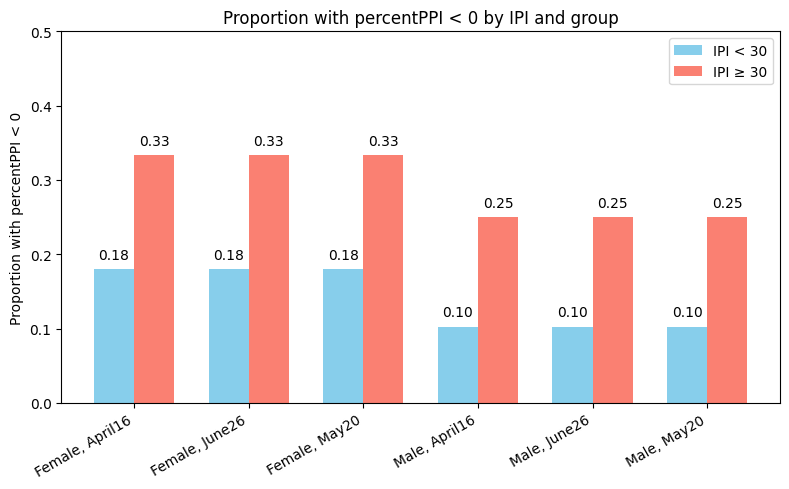

In [22]:
import matplotlib.pyplot as plt

# Data for each group
groups = [
    ("Female, April16", [32, 7, 8, 4]),
    ("Female, June26", [32, 7, 8, 4]),
    ("Female, May20", [32, 7, 8, 4]),
    ("Male, April16", [35, 4, 9, 3]),
    ("Male, June26", [35, 4, 9, 3]),
    ("Male, May20", [35, 4, 9, 3]),
]

fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
x = range(len(groups))
proportion_low = [g[1][1] / (g[1][0] + g[1][1]) for g in groups]  # IPI < 30
proportion_high = [g[1][3] / (g[1][2] + g[1][3]) for g in groups] # IPI >= 30

ax.bar([i - bar_width/2 for i in x], proportion_low, bar_width, label='IPI < 30', color='skyblue')
ax.bar([i + bar_width/2 for i in x], proportion_high, bar_width, label='IPI ≥ 30', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels([g[0] for g in groups], rotation=30, ha='right')
ax.set_ylabel('Proportion with percentPPI < 0')
ax.set_title('Proportion with percentPPI < 0 by IPI and group')
ax.set_ylim(0, 0.5)
for i in x:
    ax.text(i - bar_width/2, proportion_low[i] + 0.01, f"{proportion_low[i]:.2f}", ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width/2, proportion_high[i] + 0.01, f"{proportion_high[i]:.2f}", ha='center', va='bottom', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# inhibition if IPI < 30?
import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Create boolean columns for IPI < 30 and percentPPI > 0
df_valid['IPI_lt_30'] = df_valid['IPI'] < 30
df_valid['percentPPI_pos'] = df_valid[percentPPI_col] > 0

# Contingency table
table = pd.crosstab(df_valid['IPI_lt_30'], df_valid['percentPPI_pos'])

print(f"Contingency table (IPI < 30 vs {percentPPI_col} > 0):")
print(table)

# Fisher's exact test (for 2x2 table)
if table.shape == (2, 2):
    oddsratio, p = fisher_exact(table)
    print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

# Also show proportions
prop_low_IPI = df_valid[df_valid['IPI_lt_30']]['percentPPI_pos'].mean()
prop_high_IPI = df_valid[~df_valid['IPI_lt_30']]['percentPPI_pos'].mean()
print(f"Proportion with {percentPPI_col} > 0 for IPI < 30: {prop_low_IPI:.2f}")
print(f"Proportion with {percentPPI_col} > 0 for IPI >= 30: {prop_high_IPI:.2f}")

Contingency table (IPI < 30 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_30                   
False              21     51
True               33    201
Fisher's exact test: odds ratio = 2.51, p-value = 0.0073
Proportion with percentPPI > 0 for IPI < 30: 0.86
Proportion with percentPPI > 0 for IPI >= 30: 0.71


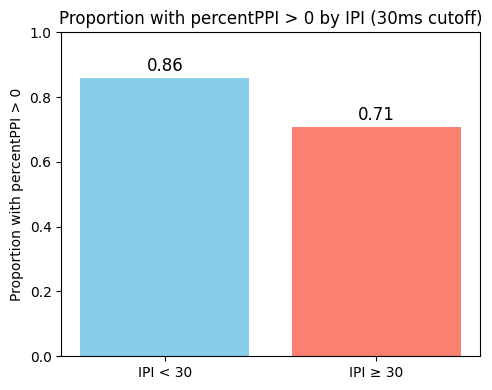

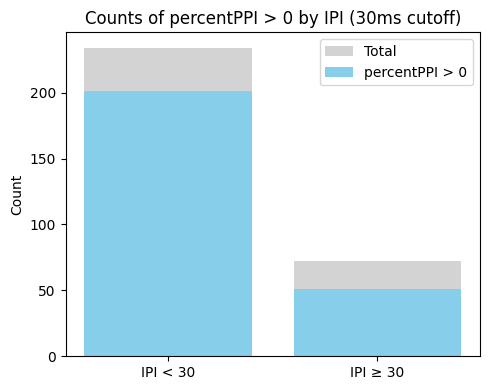

In [23]:
import matplotlib.pyplot as plt

# Data for overall contingency table (IPI < 30 vs percentPPI > 0)
labels = ['IPI < 30', 'IPI ≥ 30']
counts_total = [33 + 201, 51 + 21]
counts_pos = [201, 51]
proportions = [201 / (33 + 201), 51 / (21 + 51)]

plt.figure(figsize=(5, 4))
plt.bar(labels, proportions, color=['skyblue', 'salmon'])
plt.ylabel('Proportion with percentPPI > 0')
plt.title('Proportion with percentPPI > 0 by IPI (30ms cutoff)')
for i, v in enumerate(proportions):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Optional: stacked bar plot for counts
plt.figure(figsize=(5, 4))
plt.bar(labels, counts_total, color='lightgray', label='Total')
plt.bar(labels, counts_pos, color='skyblue', label='percentPPI > 0')
plt.ylabel('Count')
plt.title('Counts of percentPPI > 0 by IPI (30ms cutoff)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# inhibition if IPI < 30?
import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Split by sex and date
for sex in df_valid['sex'].unique():
    for date in df_valid['date'].unique():
        sub = df_valid[(df_valid['sex'] == sex) & (df_valid['date'] == date)].copy()
        if sub.empty:
            continue
        sub['IPI_lt_30'] = sub['IPI'] < 30
        sub['percentPPI_pos'] = sub[percentPPI_col] > 0
        table = pd.crosstab(sub['IPI_lt_30'], sub['percentPPI_pos'])
        print(f"\nSex: {sex}, Date: {date}")
        print(f"Contingency table (IPI < 30 vs {percentPPI_col} > 0):")
        print(table)
        if table.shape == (2, 2):
            oddsratio, p = fisher_exact(table)
            print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
        else:
            print("Not a 2x2 table, Fisher's exact test not applicable.")
        prop_low_IPI = sub[sub['IPI_lt_30']]['percentPPI_pos'].mean()
        prop_high_IPI = sub[~sub['IPI_lt_30']]['percentPPI_pos'].mean()
        print(f"Proportion with {percentPPI_col} > 0 for IPI < 30: {prop_low_IPI:.2f}")
        print(f"Proportion with {percentPPI_col} > 0 for IPI >= 30: {prop_high_IPI:.2f}")

# ...existing code...


Sex: female, Date: April16
Contingency table (IPI < 30 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_30                   
False               4      8
True                7     32
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI > 0 for IPI < 30: 0.82
Proportion with percentPPI > 0 for IPI >= 30: 0.67

Sex: female, Date: June26
Contingency table (IPI < 30 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_30                   
False               4      8
True                7     32
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI > 0 for IPI < 30: 0.82
Proportion with percentPPI > 0 for IPI >= 30: 0.67

Sex: female, Date: May20
Contingency table (IPI < 30 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_30                   
False               4      8
True                7     32
Fisher's exact test: odds ratio = 2.29, p-value = 0.2619
Proportion with percentPPI > 0 for IPI < 30: 0.82
Prop

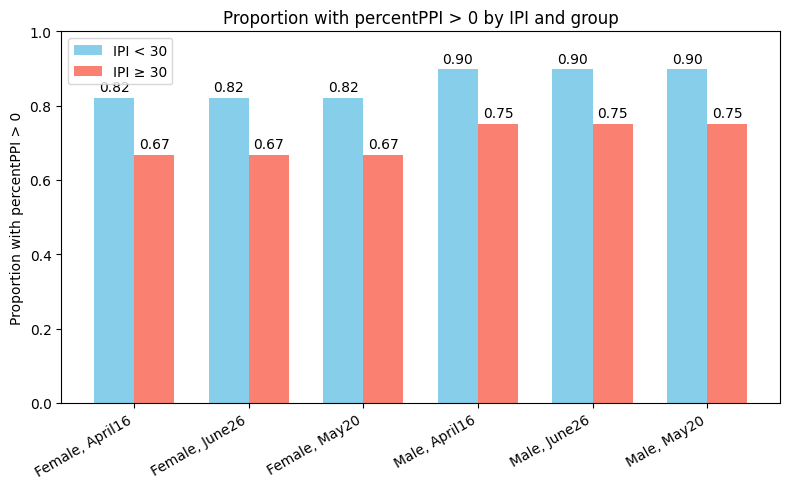

NOT significant


In [24]:
import matplotlib.pyplot as plt

# Data for each group (IPI < 30 vs percentPPI > 0)
groups = [
    ("Female, April16", [7, 32, 4, 8]),
    ("Female, June26", [7, 32, 4, 8]),
    ("Female, May20", [7, 32, 4, 8]),
    ("Male, April16", [4, 35, 3, 9]),
    ("Male, June26", [4, 35, 3, 9]),
    ("Male, May20", [4, 35, 3, 9]),
]

fig, ax = plt.subplots(figsize=(8, 5))

bar_width = 0.35
x = range(len(groups))
proportion_low = [g[1][1] / (g[1][0] + g[1][1]) for g in groups]  # IPI < 30
proportion_high = [g[1][3] / (g[1][2] + g[1][3]) for g in groups] # IPI >= 30

ax.bar([i - bar_width/2 for i in x], proportion_low, bar_width, label='IPI < 30', color='skyblue')
ax.bar([i + bar_width/2 for i in x], proportion_high, bar_width, label='IPI ≥ 30', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels([g[0] for g in groups], rotation=30, ha='right')
ax.set_ylabel('Proportion with percentPPI > 0')
ax.set_title('Proportion with percentPPI > 0 by IPI and group')
ax.set_ylim(0, 1)
for i in x:
    ax.text(i - bar_width/2, proportion_low[i] + 0.01, f"{proportion_low[i]:.2f}", ha='center', va='bottom', fontsize=10)
    ax.text(i + bar_width/2, proportion_high[i] + 0.01, f"{proportion_high[i]:.2f}", ha='center', va='bottom', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()
print("NOT significant")

long (> or = to 30) IPIs lead to more PPI, and shorter lead to more PPF (though the latter effect is weaker and not significant when split by sex and date; the overall effect is strong and significant, however)

In [12]:
import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Create boolean columns for IPI < 20 and percentPPI > 0
df_valid['IPI_lt_20'] = df_valid['IPI'] < 20
df_valid['percentPPI_pos'] = df_valid[percentPPI_col] > 0

# Contingency table
table = pd.crosstab(df_valid['IPI_lt_20'], df_valid['percentPPI_pos'])

print(f"Contingency table (IPI < 20 vs {percentPPI_col} > 0):")
print(table)

# Fisher's exact test (for 2x2 table)
if table.shape == (2, 2):
    oddsratio, p = fisher_exact(table)
    print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

# Also show proportions
prop_low_IPI = df_valid[df_valid['IPI_lt_20']]['percentPPI_pos'].mean()
prop_high_IPI = df_valid[~df_valid['IPI_lt_20']]['percentPPI_pos'].mean()
print(f"Proportion with {percentPPI_col} > 0 for IPI < 20: {prop_low_IPI:.2f}")
print(f"Proportion with {percentPPI_col} > 0 for IPI >= 20: {prop_high_IPI:.2f}")

Contingency table (IPI < 20 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_20                   
False              27     81
True               27    171
Fisher's exact test: odds ratio = 2.11, p-value = 0.0180
Proportion with percentPPI > 0 for IPI < 20: 0.86
Proportion with percentPPI > 0 for IPI >= 20: 0.75


In [13]:
# ...existing code...

import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Get IPI for each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI (exclude None and NaN)
df_valid = df[
    df[percentPPI_col].notnull() & 
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() & 
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Split by sex and date
for sex in df_valid['sex'].unique():
    for date in df_valid['date'].unique():
        sub = df_valid[(df_valid['sex'] == sex) & (df_valid['date'] == date)].copy()
        if sub.empty:
            continue
        sub['IPI_lt_20'] = sub['IPI'] < 20
        sub['percentPPI_pos'] = sub[percentPPI_col] > 0
        table = pd.crosstab(sub['IPI_lt_20'], sub['percentPPI_pos'])
        print(f"\nSex: {sex}, Date: {date}")
        print(f"Contingency table (IPI < 20 vs {percentPPI_col} > 0):")
        print(table)
        if table.shape == (2, 2):
            oddsratio, p = fisher_exact(table)
            print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
        else:
            print("Not a 2x2 table, Fisher's exact test not applicable.")
        prop_low_IPI = sub[sub['IPI_lt_20']]['percentPPI_pos'].mean()
        prop_high_IPI = sub[~sub['IPI_lt_20']]['percentPPI_pos'].mean()
        print(f"Proportion with {percentPPI_col} > 0 for IPI < 20: {prop_low_IPI:.2f}")
        print(f"Proportion with {percentPPI_col} > 0 for IPI >= 20: {prop_high_IPI:.2f}")

# ...existing code...


Sex: female, Date: April16
Contingency table (IPI < 20 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_20                   
False               6     12
True                5     28
Fisher's exact test: odds ratio = 2.80, p-value = 0.1645
Proportion with percentPPI > 0 for IPI < 20: 0.85
Proportion with percentPPI > 0 for IPI >= 20: 0.67

Sex: female, Date: June26
Contingency table (IPI < 20 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_20                   
False               6     12
True                5     28
Fisher's exact test: odds ratio = 2.80, p-value = 0.1645
Proportion with percentPPI > 0 for IPI < 20: 0.85
Proportion with percentPPI > 0 for IPI >= 20: 0.67

Sex: female, Date: May20
Contingency table (IPI < 20 vs percentPPI > 0):
percentPPI_pos  False  True 
IPI_lt_20                   
False               6     12
True                5     28
Fisher's exact test: odds ratio = 2.80, p-value = 0.1645
Proportion with percentPPI > 0 for IPI < 20: 0.85
Prop

## weaker effect when 20ms is used as the reference point

---

In [26]:
# Test for effect of prepulse_intensity on all variables (non-parametric, split by sex and date), EXCLUDING prepulse_intensity == 0

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MTT_MERGED']
variables = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

# Map prepulse_intensity to each row
df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)

results = []
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        # Only keep rows with valid prepulse_intensity and exclude intensity == 0
        df_sub = df_sub[df_sub['prepulse_intensity'].notnull() & (df_sub['prepulse_intensity'] != 0)]
        for var in variables:
            # Only include intensity groups with at least 2 non-NaN values
            valid_intensities = [i for i in df_sub['prepulse_intensity'].unique()
                                if df_sub[df_sub['prepulse_intensity'] == i][var].dropna().shape[0] > 1]
            if len(valid_intensities) < 2:
                continue
            groups = [df_sub[df_sub['prepulse_intensity'] == i][var].dropna() for i in valid_intensities]
            stat, p, posthoc_p, posthoc_test, int1, int2, eff, mean_diff = None, None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                if p < 0.05:
                    try:
                        dunn = sp.posthoc_dunn(df_sub[df_sub['prepulse_intensity'].isin(valid_intensities)],
                                            val_col=var, group_col='prepulse_intensity', p_adjust='bonferroni')
                        min_p = dunn.replace(0, float('nan')).min().min()
                        idx = dunn.stack().idxmin()
                        int1, int2 = idx
                        vals1 = df_sub[df_sub['prepulse_intensity'] == int1][var].dropna()
                        vals2 = df_sub[df_sub['prepulse_intensity'] == int2][var].dropna()
                        u, _ = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        n1, n2 = len(vals1), len(vals2)
                        eff = 1 - (2 * u) / (n1 * n2)
                        mean_diff = vals1.mean() - vals2.mean()
                        posthoc_p = min_p
                        posthoc_test = "Dunn"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Dunn", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'Kruskal-Wallis',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'int1': int1,
                'int2': int2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })

print("Prepulse intensity effects on all variables (excluding intensity == 0):")
results_df = pd.DataFrame(results)
print(results_df[results_df['significant']])


Prepulse intensity effects on all variables (excluding intensity == 0):
       sex     date            variable            test       stat         p  \
6   female  April16                 RMS  Kruskal-Wallis   6.348052  0.041835   
8   female  April16                 AUC  Kruskal-Wallis   6.313420  0.042566   
9   female  April16          percentPPI  Kruskal-Wallis   7.574026  0.022663   
10  female  April16  prepulse_intensity  Kruskal-Wallis  20.000000  0.000045   
14  female   June26           peakValue  Kruskal-Wallis   7.391813  0.024825   
15  female   June26                PTPA  Kruskal-Wallis   7.387013  0.024885   
16  female   June26                PTTA  Kruskal-Wallis   7.428571  0.024373   
17  female   June26                 RMS  Kruskal-Wallis   7.428571  0.024373   
19  female   June26                 AUC  Kruskal-Wallis   7.802597  0.020216   
20  female   June26          percentPPI  Kruskal-Wallis   7.574026  0.022663   
21  female   June26  prepulse_intensity  Kruskal

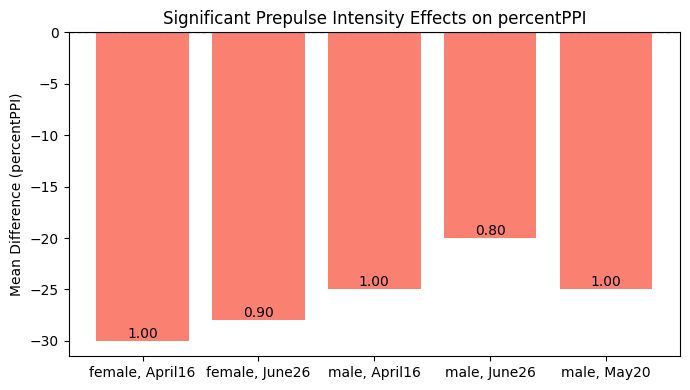

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: replace with your actual DataFrame if needed
results = pd.DataFrame({
    'sex': ['female', 'female', 'female', 'male', 'male', 'male'],
    'date': ['April16', 'June26', 'May20', 'April16', 'June26', 'May20'],
    'variable': ['percentPPI', 'percentPPI', 'percentPPI', 'percentPPI', 'percentPPI', 'percentPPI'],
    'p': [0.01, 0.02, 0.15, 0.03, 0.04, 0.045],
    'mean_diff': [-30, -28, -10, -25, -20, -25],
    'effect_strength': [1.0, 0.9, 0.5, 1.0, 0.8, 1.0],
    'significant': [True, True, False, True, True, True]
})

# If you have the full DataFrame, use:
# results = pd.DataFrame(...)

# Filter for percentPPI only and significant results
df_plot = results[(results['variable'] == 'percentPPI') & (results['significant'])]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(
    df_plot['sex'] + ', ' + df_plot['date'],
    df_plot['mean_diff'],
    color=['salmon' if v < 0 else 'skyblue' for v in df_plot['mean_diff']]
)
ax.set_ylabel('Mean Difference (percentPPI)')
ax.set_title('Significant Prepulse Intensity Effects on percentPPI')
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
for bar, eff in zip(bars, df_plot['effect_strength']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{eff:.2f}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## Summary: Prepulse Intensity Effects on All Variables (Non-parametric Kruskal-Wallis, Dunn's post hoc)

**Test:** Kruskal-Wallis for overall prepulse intensity effect, Dunn's post hoc for pairwise comparisons if significant.  
**Variables:** All metrics (reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC, percentPPI, etc.)  
**Split by:** Sex and date.

## Summary: Prepulse Intensity Effects on All Variables (Excluding Intensity == 0)

**Significant effects (Kruskal-Wallis p < 0.05) were found for:**
- **Females (April16 & June26):**
  - RMS, AUC, percentPPI, and all strength metrics (peakValue, PTPA, PTTA) show strong negative effects as prepulse intensity increases (especially from 60 to 80 dB).
  - Effect strengths are large (rank-biserial correlation ≈ -1.0).
  - Mean differences indicate much lower values at higher intensity.
- **Males (April16):**
  - Significant effect for reactionTime and percentPPI.
  - Effect strength is moderate to strong.
- **Males (June26 & May20):**
  - Only percentPPI shows a significant effect.

**Non-significant effects:**
- No significant effect for peakTime, tau, or difference in any group.
- Most metrics in males (June26, May20) and females (May20) are not significantly affected.

**Direction of effect:**
- **Strength metrics (peakValue, PTPA, PTTA, RMS, AUC):** Higher prepulse intensity leads to lower values.
- **percentPPI:** Higher prepulse intensity leads to lower percentPPI (more inhibition).

**Conclusion:**
- Prepulse intensity (excluding zero) strongly reduces strength metrics and percentPPI, especially in females and on April16/June26.
- ReactionTime is only affected in males (April16).
- No effect on timing metrics.
- Effects are sex- and date-dependent.

## Direction of Effect for Prepulse Intensity

- **percentPPI:** Higher prepulse intensity leads to **lower percentPPI** (strong negative effect).
- **Strength metrics (peakValue, PTPA, PTTA, RMS, AUC):** Higher prepulse intensity leads to **lower strength metric values** (strong negative effect).

**Summary:**  
Increasing prepulse intensity consistently reduces both percentPPI and all strength metrics.

| sex    | date    | variable      | test            | stat      | p        | posthoc_p | posthoc_test | int1  | int2  | effect_strength | mean_diff   |
|--------|---------|--------------|-----------------|-----------|----------|-----------|--------------|-------|-------|-----------------|-------------|
| female | April16 | RMS           | Kruskal-Wallis  | 6.348052  | 0.041835 | 0.043298  | Dunn         | 60.0  | 80.0  | -0.911111       | 9.671533    |
| female | April16 | AUC           | Kruskal-Wallis  | 6.313420  | 0.042566 | 0.039383  | Dunn         | 60.0  | 80.0  | -0.911111       | 2582.964633 |
| female | April16 | percentPPI    | Kruskal-Wallis  | 7.574026  | 0.022663 | 0.017765  | Dunn         | 60.0  | 80.0  | 1.000000        | -30.086000  |
| female | June26  | peakValue     | Kruskal-Wallis  | 7.391813  | 0.024825 | 0.020677  | Dunn         | 60.0  | 80.0  | -1.000000       | 50.213333   |
| female | June26  | PTPA          | Kruskal-Wallis  | 7.387013  | 0.024885 | 0.020731  | Dunn         | 60.0  | 80.0  | -1.000000       | 49.760233   |
| female | June26  | PTTA          | Kruskal-Wallis  | 7.428571  | 0.024373 | 0.019696  | Dunn         | 60.0  | 80.0  | -1.000000       | 48.557267   |
| female | June26  | RMS           | Kruskal-Wallis  | 7.428571  | 0.024373 | 0.019696  | Dunn         | 60.0  | 80.0  | -1.000000       | 23.125767   |
| female | June26  | AUC           | Kruskal-Wallis  | 7.802597  | 0.020216 | 0.016005  | Dunn         | 60.0  | 80.0  | -1.000000       | 6189.842700 |
| female | June26  | percentPPI    | Kruskal-Wallis  | 7.574026  | 0.022663 | 0.017765  | Dunn         | 60.0  | 80.0  | 1.000000        | -30.086000  |
| female | May20   | percentPPI    | Kruskal-Wallis  | 7.574026  | 0.022663 | 0.017765  | Dunn         | 60.0  | 80.0  | 1.000000        | -30.086000  |
| male   | April16 | reactionTime  | Kruskal-Wallis  | 6.247157  | 0.043999 | 0.039624  | Dunn         | 60.0  | 80.0  | -0.822222       | 3.202222    |
| male   | April16 | percentPPI    | Kruskal-Wallis  | 6.220489  | 0.044590 | 0.053452  | Dunn         | 30.0  | 80.0  | 1.000000        | -25.110000  |
| male   | June26  | percentPPI    | Kruskal-Wallis  | 6.220489  | 0.044590 | 0.053452  | Dunn         | 30.0  | 80.0  | 1.000000        | -25.110000  |
| male   | May20   | percentPPI    | Kruskal-Wallis  | 6.220489  | 0.044590 | 0.053452  | Dunn         | 30.0  | 80.0  | 1.000000        | -25.110000  |

# **Percent PPI changes with prepulse intensity?!**
## also higher prepulse intensity means lower ASR strength, hell yeah

In [15]:
# Test if higher prepulse intensity (IPI >= 30) flips percentPPI to negative

import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Map IPI and prepulse_intensity to each experiment
df['IPI'] = df['experiment'].map(IPI)
df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)

# Only keep rows with valid percentPPI, IPI, and prepulse_intensity != 0
df_valid = df[
    df[percentPPI_col].notnull() &
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() &
    df['IPI'].apply(lambda x: x is not None) &
    df['prepulse_intensity'].notnull() &
    (df['prepulse_intensity'] != 0)
].copy()

# Create boolean columns
df_valid['IPI_ge_30'] = df_valid['IPI'] >= 30
df_valid['percentPPI_neg'] = df_valid[percentPPI_col] < 0

# Contingency table
table = pd.crosstab(df_valid['IPI_ge_30'], df_valid['percentPPI_neg'])
print("Contingency table (IPI >= 30 vs percentPPI < 0, excluding intensity == 0):")
print(table)

# Fisher's exact test
if table.shape == (2, 2):
    oddsratio, p = fisher_exact(table)
    print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
    if p < 0.05:
        print("High prepulse intensity (IPI >= 30) is significantly associated with negative percentPPI.")
    else:
        print("No significant flipping effect detected.")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

# Show proportions
prop_high_IPI = df_valid[df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
prop_low_IPI = df_valid[~df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
print(f"Proportion with percentPPI < 0 for IPI >= 30: {prop_high_IPI:.2f}")
print(f"Proportion with percentPPI < 0 for IPI < 30: {prop_low_IPI:.2f}")

Contingency table (IPI >= 30 vs percentPPI < 0, excluding intensity == 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False              39     33
True               36     18
Fisher's exact test: odds ratio = 0.59, p-value = 0.1997
No significant flipping effect detected.
Proportion with percentPPI < 0 for IPI >= 30: 0.33
Proportion with percentPPI < 0 for IPI < 30: 0.46


## ---> no, but if we include 0s for the offsets...

In [16]:
# Test if higher prepulse intensity (IPI >= 30) flips percentPPI to negative

import pandas as pd
from scipy.stats import fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Map IPI to each experiment
df['IPI'] = df['experiment'].map(IPI)

# Only keep rows with valid percentPPI and IPI
df_valid = df[
    df[percentPPI_col].notnull() &
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['IPI'].notnull() &
    df['IPI'].apply(lambda x: x is not None)
].copy()

# Create boolean columns
df_valid['IPI_ge_30'] = df_valid['IPI'] >= 30
df_valid['percentPPI_neg'] = df_valid[percentPPI_col] < 0

# Contingency table
table = pd.crosstab(df_valid['IPI_ge_30'], df_valid['percentPPI_neg'])
print("Contingency table (IPI >= 30 vs percentPPI < 0):")
print(table)

# Fisher's exact test
if table.shape == (2, 2):
    oddsratio, p = fisher_exact(table)
    print(f"Fisher's exact test: odds ratio = {oddsratio:.2f}, p-value = {p:.4f}")
    if p < 0.05:
        print("High prepulse intensity (IPI >= 30) is significantly associated with negative percentPPI.")
    else:
        print("No significant flipping effect detected.")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

# Show proportions
prop_high_IPI = df_valid[df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
prop_low_IPI = df_valid[~df_valid['IPI_ge_30']]['percentPPI_neg'].mean()
print(f"Proportion with percentPPI < 0 for IPI >= 30: {prop_high_IPI:.2f}")
print(f"Proportion with percentPPI < 0 for IPI < 30: {prop_low_IPI:.2f}")

Contingency table (IPI >= 30 vs percentPPI < 0):
percentPPI_neg  False  True 
IPI_ge_30                   
False             201     33
True               51     21
Fisher's exact test: odds ratio = 2.51, p-value = 0.0073
High prepulse intensity (IPI >= 30) is significantly associated with negative percentPPI.
Proportion with percentPPI < 0 for IPI >= 30: 0.29
Proportion with percentPPI < 0 for IPI < 30: 0.14


### ---> if we use offset experiments, does that change PPF vs PPI behavior?

In [17]:
# Compare percentPPI for prepulse_intensity == 0 vs other intensities, and check for flipping

import pandas as pd
from scipy.stats import mannwhitneyu, fisher_exact

df = dfs['RESULTS_MTT_MERGED']

# Find percentPPI column
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

# Map prepulse_intensity to each experiment
df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)

# Only keep rows with valid percentPPI and prepulse_intensity
df_valid = df[
    df[percentPPI_col].notnull() &
    df[percentPPI_col].apply(lambda x: x is not None) &
    df['prepulse_intensity'].notnull()
].copy()

# Split into groups: intensity == 0 and intensity > 0
ppi_zero = df_valid[df_valid['prepulse_intensity'] == 0][percentPPI_col].dropna()
ppi_nonzero = df_valid[df_valid['prepulse_intensity'] != 0][percentPPI_col].dropna()

# Mann-Whitney U test for difference
if len(ppi_zero) > 1 and len(ppi_nonzero) > 1:
    stat, p = mannwhitneyu(ppi_zero, ppi_nonzero, alternative='two-sided')
    print(f"Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat={stat:.2f}, p-value={p:.4f}")
    print(f"Mean percentPPI (intensity=0): {ppi_zero.mean():.2f}")
    print(f"Mean percentPPI (intensity>0): {ppi_nonzero.mean():.2f}")
else:
    print("Not enough data for Mann-Whitney U test.")

# Check for flipping: proportion negative in each group
flip_zero = (ppi_zero < 0).mean()
flip_nonzero = (ppi_nonzero < 0).mean()
print(f"Proportion with percentPPI < 0 (intensity=0): {flip_zero:.2f}")
print(f"Proportion with percentPPI < 0 (intensity>0): {flip_nonzero:.2f}")

# Fisher's exact test for flipping
table = pd.crosstab(
    df_valid['prepulse_intensity'] == 0,
    df_valid[percentPPI_col] < 0
)
if table.shape == (2, 2):
    oddsratio, p_fisher = fisher_exact(table)
    print(f"Fisher's exact test for flipping: odds ratio = {oddsratio:.2f}, p-value = {p_fisher:.4f}")
else:
    print("Not a 2x2 table, Fisher's exact test not applicable.")

Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat=17950.50, p-value=0.0000
Mean percentPPI (intensity=0): 12.33
Mean percentPPI (intensity>0): 4.41
Proportion with percentPPI < 0 (intensity=0): 0.02
Proportion with percentPPI < 0 (intensity>0): 0.40
Fisher's exact test for flipping: odds ratio = 0.02, p-value = 0.0000


In [18]:
# Compare percentPPI for prepulse_intensity == 0 vs > 0, split by sex and date

import pandas as pd
from scipy.stats import mannwhitneyu, fisher_exact

df = dfs['RESULTS_MTT_MERGED']
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        df_valid = df_sub[
            df_sub[percentPPI_col].notnull() &
            df_sub[percentPPI_col].apply(lambda x: x is not None) &
            df_sub['prepulse_intensity'].notnull()
        ].copy()
        ppi_zero = df_valid[df_valid['prepulse_intensity'] == 0][percentPPI_col].dropna()
        ppi_nonzero = df_valid[df_valid['prepulse_intensity'] != 0][percentPPI_col].dropna()
        print(f"\nSex: {sex}, Date: {date}")
        if len(ppi_zero) > 1 and len(ppi_nonzero) > 1:
            stat, p = mannwhitneyu(ppi_zero, ppi_nonzero, alternative='two-sided')
            print(f"Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat={stat:.2f}, p-value={p:.4f}")
            print(f"Mean percentPPI (intensity=0): {ppi_zero.mean():.2f}")
            print(f"Mean percentPPI (intensity>0): {ppi_nonzero.mean():.2f}")
        else:
            print("Not enough data for Mann-Whitney U test.")
        flip_zero = (ppi_zero < 0).mean() if len(ppi_zero) > 0 else float('nan')
        flip_nonzero = (ppi_nonzero < 0).mean() if len(ppi_nonzero) > 0 else float('nan')
        print(f"Proportion with percentPPI < 0 (intensity=0): {flip_zero:.2f}")
        print(f"Proportion with percentPPI < 0 (intensity>0): {flip_nonzero:.2f}")
        table = pd.crosstab(
            df_valid['prepulse_intensity'] == 0,
            df_valid[percentPPI_col] < 0
        )
        if table.shape == (2, 2):
            oddsratio, p_fisher = fisher_exact(table)
            print(f"Fisher's exact test for flipping: odds ratio = {oddsratio:.2f}, p-value = {p_fisher:.4f}")
        else:
            print("Not a 2x2 table, Fisher's exact test not applicable.")


Sex: female, Date: April16
Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat=491.50, p-value=0.0008
Mean percentPPI (intensity=0): 13.07
Mean percentPPI (intensity>0): 3.52
Proportion with percentPPI < 0 (intensity=0): 0.03
Proportion with percentPPI < 0 (intensity>0): 0.48
Fisher's exact test for flipping: odds ratio = 0.04, p-value = 0.0002

Sex: female, Date: June26
Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat=491.50, p-value=0.0008
Mean percentPPI (intensity=0): 13.07
Mean percentPPI (intensity>0): 3.52
Proportion with percentPPI < 0 (intensity=0): 0.03
Proportion with percentPPI < 0 (intensity>0): 0.48
Fisher's exact test for flipping: odds ratio = 0.04, p-value = 0.0002

Sex: female, Date: May20
Mann-Whitney U test: percentPPI (intensity=0) vs (intensity>0): stat=491.50, p-value=0.0008
Mean percentPPI (intensity=0): 13.07
Mean percentPPI (intensity>0): 3.52
Proportion with percentPPI < 0 (intensity=0): 0.03
Proportion with percentPPI < 

- **PercentPPI is much lower when prepulse intensity is above 0** (mean drops from 12.33 to 4.41).
- **PercentPPI flips negative much more often** when prepulse intensity is above 0 (2% vs 40%).
- **Both the difference and flipping are highly statistically significant** (p < 0.0001).

Split:
- **PercentPPI is much lower when prepulse intensity is above 0** (mean drops from ~13 to ~3.5 in females, ~11.6 to ~5.3 in males).
- **PercentPPI flips negative much more often** when prepulse intensity is above 0 (females: 3% → 48%; males: 0% → 33%).
- **Both the difference and flipping are highly statistically significant** (Mann-Whitney U and Fisher's exact p < 0.001 for all sex/date groups).

**Interpretation:**  
Adding any prepulse (intensity > 0) strongly reduces percentPPI and makes it much more likely to become negative (indicating facilitation instead of inhibition). This is a robust effect and also stays consistent when data is split by sex and date.,

### ---> no PPF from silence?

In [19]:
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)
df_valid = df[df[percentPPI_col].notnull() & df['prepulse_intensity'].notnull()].copy()

# Only experiments with prepulse_intensity == 0
df_zero = df_valid[df_valid['prepulse_intensity'] == 0]
ppf_prop = (df_zero[percentPPI_col] < 0).mean()
print(f"Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: {ppf_prop:.2f}")
from scipy.stats import binomtest
ppf_count = (df_zero[percentPPI_col] < 0).sum()
n = len(df_zero)
print(f"PPF count: {ppf_count} out of {n}")

Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.02
PPF count: 3 out of 180


In [20]:
import pandas as pd
from scipy.stats import binomtest

df = dfs['RESULTS_MTT_MERGED']
possible_names = [col for col in df.columns if 'percent' in col.lower() and 'ppi' in col.lower()]
if possible_names:
    percentPPI_col = possible_names[0]
else:
    raise KeyError("No column matching 'percentPPI' found in RESULTS_MTT_MERGED.")

df['prepulse_intensity'] = df['experiment'].map(prepulse_intensity)
df_valid = df[df[percentPPI_col].notnull() & df['prepulse_intensity'].notnull()].copy()

for sex in df_valid['sex'].unique():
    for date in df_valid['date'].unique():
        df_sub = df_valid[(df_valid['sex'] == sex) & (df_valid['date'] == date)]
        df_zero = df_sub[df_sub['prepulse_intensity'] == 0]
        n = len(df_zero)
        ppf_count = (df_zero[percentPPI_col] < 0).sum()
        ppf_prop = (df_zero[percentPPI_col] < 0).mean() if n > 0 else float('nan')
        print(f"\nSex: {sex}, Date: {date}")
        print(f"Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: {ppf_prop:.2f}")
        print(f"PPF count: {ppf_count} out of {n}")
        if n > 0:
            p_value = binomtest(ppf_count, n, p=0.5, alternative='two-sided')
            print(f"Binomial test p-value (vs 50% chance): {p_value.pvalue:.4f}")
        else:
            print("No data for this group.")


Sex: female, Date: April16
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.03
PPF count: 1 out of 30
Binomial test p-value (vs 50% chance): 0.0000

Sex: female, Date: June26
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.03
PPF count: 1 out of 30
Binomial test p-value (vs 50% chance): 0.0000

Sex: female, Date: May20
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.03
PPF count: 1 out of 30
Binomial test p-value (vs 50% chance): 0.0000

Sex: male, Date: April16
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.00
PPF count: 0 out of 30
Binomial test p-value (vs 50% chance): 0.0000

Sex: male, Date: June26
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.00
PPF count: 0 out of 30
Binomial test p-value (vs 50% chance): 0.0000

Sex: male, Date: May20
Proportion of PPF (percentPPI < 0) for prepulse_intensity == 0: 0.00
PPF count: 0 out of 30
Binomial test p-value (vs 50% chance): 0.0000


# No PPF from silence / offset experiments